In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import pandas as pd
from pandas import Timedelta as td
from queue import PriorityQueue
from scipy import stats
import networkx as nx
from tqdm import tqdm

In [ ]:
# Parameters of the simulation
AVG_BIKE_LEN_M = 2  # length of an average bike
AVG_WALK_LEN_M = 0.5  # length of a walking person
AVG_CAR_LEN_M = 6  # length of an average car in meters (including space before and after that it needs to move)

AVG_BIKE_SPEED_KMH = 22
AVG_WALK_SPEED_KMH = 5
# Cars are assumed to always drive at speed limit

# for occupancy < 10%: 100% speed, above 20%: linearly speed 100% -> 0% as occupancy 10% -> 60%
CAR_OCCUPANCY_TO_SPEED_MULT = lambda occ: max(0, min(1, 1 - (occ - 0.1) / (1 - 0.3)))
# for occupancy < 50%: 100% speed, above 20%: linearly speed 100% -> 16% (slow walking) as occupancy 50% -> 100%
BIKE_OCCUPANCY_TO_SPEED_MULT = lambda occ: max(0, min(1, 1 - (occ - 0.5) / (1 - 0.4)))
# for occupancy < 50%: 100% speed, above 20%: linearly speed 100% -> 37% (very slow walking) as occupancy 50% -> 100%
WALK_OCCUPANCY_TO_SPEED_MULT = lambda occ: max(0, min(1, 1 - (occ - 0.5) / (1 - 0.2)))

AVG_LENS = (AVG_CAR_LEN_M, AVG_BIKE_LEN_M, AVG_WALK_LEN_M)
OCCUPANCY_TO_SPEED_MULT = (CAR_OCCUPANCY_TO_SPEED_MULT, BIKE_OCCUPANCY_TO_SPEED_MULT, WALK_OCCUPANCY_TO_SPEED_MULT)

# The streets are represented as a graph; each node is an intersection
# Only top right triangle needs to be filled, since the graph is not directed
streets = np.array([
    # [from, to, length, speedlimit, carlanes, bikelanes, sidewalks, is bidirectional]
    [0, 1, 300, 50, 1, 1, 4, 1],
    [1, 2, 300, 50, 1, 1, 4, 1],
    [2, 3, 220, 50, 1, 0, 2, 1],
    [3, 4, 170, 50, 1, 0, 2, 1],
    [4, 5, 200, 50, 2, 0, 2, 1],
    [5, 6, 120, 50, 2, 0, 2, 1],
    [6, 7, 300, 50, 2, 0, 2, 1],
    [7, 8, 200, 50, 1, 1, 2, 1],
    [8, 0, 170, 30, 1, 1, 2, 1],
    [8, 9, 250, 30, 1, 0, 2, 1],
    [1, 9, 250, 30, 1, 0, 2, 1],
    [1, 10, 250, 30, 1, 0, 2, 1],
    [9, 10, 120, 30, 1, 0, 2, 1],
    [3, 10, 170, 30, 1, 0, 2, 1],
    [6, 9, 170, 30, 1, 0, 2, 1],
    [5, 10, 170, 30, 1, 0, 2, 1],
    [7, 11, 140, 50, 1, 1, 2, 1],
    [11, 12, 230, 50, 1, 1, 2, 1],
    [12, 13, 150, 50, 1, 1, 2, 1],
    [13, 14, 300, 50, 2, 1, 2, 1],
    [14, 15, 120, 50, 2, 1, 2, 1],
    [15, 16, 200, 50, 2, 1, 2, 1],
    [16, 17, 130, 50, 1, 1, 2, 1],
    [17, 4, 120, 50, 1, 1, 2, 1],
    [11, 18, 250, 30, 1, 0, 2, 1],
    [12, 18, 200, 30, 1, 0, 2, 1],
    [14, 18, 220, 30, 1, 0, 2, 1],
    [18, 19, 200, 30, 1, 0, 2, 1],
    [17, 19, 200, 30, 1, 0, 2, 1],
    [5, 19, 250, 30, 1, 0, 2, 1],
    [6, 19, 260, 30, 1, 0, 2, 1],
    [15, 19, 400, 30, 1, 0, 2, 1],
    [14, 19, 460, 30, 1, 0, 2, 1],
])

# Preprocess streets
# Add bidirectional streets from the other direction
bidir = streets[streets[:, -1] == 1].copy()
bidir[:, [0, 1]] = bidir[:, [1, 0]]
streets = np.vstack([streets, bidir])

n_nodes = int(streets[:, :2].max() + 1)
streets[:, -1] = np.arange(len(streets))  # indices of streets
piv_streets = (pd.pivot(pd.DataFrame([streets[:, 0], streets[:, 1], streets[:, 2:]]).T, index=0, columns=1, values=2)
               .reindex(range(n_nodes)).reindex(range(n_nodes), axis=1))

piv_streets = np.array([[list(v) if type(v) == np.ndarray else [0, 0, 0, 0, 0, 0] for v in row]
                        for row in piv_streets.values])

# piv_streets[i, j, c] = characteristic `c` of street between nodes `i` and `j`, where `c` is one of the following:
DIST = 0
MAX_SPEED = 1
CAR_LANES = 2
BIKE_LANES = 3
SIDEWALKS = 4
STREET_ID = 5

ind_to_transp = ['car', 'bike', 'walk']
transp_to_ind = {'car': 0, 'bike': 1, 'walk': 2}

In [3]:
class Environment:
    def __init__(self, events: list, run_for=td('1 day'), timeunit=td('1 minute'), store_history=False):
        """
        :param list[Event] events: list of Event instances; each event will be triggered at each time step
        :param pd.Timedelta run_for: how long the simulation will run for
        :param timeunit: duration of one step of the simulation; the lower = slower & more accurate
        :param store_history: whether the config at each step should be stored (e.g., queue lengths etc)
        """
        self.timeunit = timeunit
        self.timeout = run_for
        self.events = events

        # a Series of, e.g.: ['0 days 00:00:00', '0 days 00:01:00', ... '1 days 23:59:00', '2 days 00:00:00']
        self.timeline = pd.timedelta_range(start=td('0'), end=run_for, freq=timeunit)

        self.config = {}  # a pool of *global* variables shared by all events in the environment
        self.config['events'] = events  # store events into  config as well

        self.store_history = store_history
        if store_history:
            self.config_history = [] * len(self.timeline)  # configs before each of timestamps in `timeline`

        # Let each event initialize config
        for event in events:
            event.init_config(self.config)

    def run(self, verbose_func=lambda t, c: None, termination_func=lambda t, c: False):
        """
        Runs the simulation by running every time period
        :param verbose_func: function to be called on every step with two arguments: time and config.
        :param termination_func: function to be called on every step with two arguments: time and config,
            and if it returns True, the simulation will be terminated
        """
        periods = list(zip(self.timeline[:-1], self.timeline[1:]))  # eg: [(00:00, 00:01), ..., (00:59, 00:00)]
        verbose_func(self.timeline[0], self.config)
        for start, end in tqdm(periods):
            if self.store_history:
                self.config_history.append(copy.deepcopy(self.config))

            for event in self.events:
                event.trigger(start, end)

            verbose_func(end, self.config)

            if termination_func(end, self.config):
                break

        if self.store_history:
            self.config_history.append(self.config)


class Event:
    def __init__(self):
        self.config = None  # will be initialized in init_config() when called from Environment's __init__()

    def init_config(self, config):
        self.config = config

    def trigger(self, start_time, end_time):
        pass


def street_exists(frm, to):
    return piv_streets[frm, to, DIST] != 0


class City(Event):
    def __init__(self):
        super().__init__()

    def init_config(self, config):
        super().init_config(config)
        self.config['travelers'] = []  # list of existing travelers
        # number of [cars, bikes, pedestrians] on each of streets
        self.config['traffic'] = np.zeros((len(streets) + 1, 3))

        # for statistics
        self.config['trips'] = []
        self.config['vehicles'] = []


class Traveler(Event):
    STATES = ('IDLE', 'TRAVELING', 'DONE')

    def __init__(self, location, destination, speed_multiplier=1):
        """
        :param speed_multiplier: how must faster the person walks/embarks/disembarks than average (greater=faster)
        """
        super().__init__()
        self.loc = location
        self.dest = destination
        self.state = 'IDLE'

        self.speediness = speed_multiplier

        self.traveling_by = 'walk'  # 'car' or 'bike'
        self.path = [location]

        self._trip_started_at = td('0')

        # service variable within trips (differens from one node to next)
        self._departed_at = td('0')
        self._departed_from = 0  # index of self.path
        self._arriving_to = 1
        self._arriving_at = td('0')

    def trigger(self, start_time, end_time):
        if self._check_if_arrived(start_time):  # has already arrived
            return
        if self.state == 'IDLE':  # time to wake up
            self._trip_started_at = start_time
            self._departed_at = start_time
            self._departed_from = 0  # departed from first element of self.path, whatever node that may be

            path_car, dist_car = self.path_between(self.loc, self.dest, by='car')
            path_bike, dist_bike = self.path_between(self.loc, self.dest, by='bike')
            path_walk, dist_walk = self.path_between(self.loc, self.dest, by='walk')

            fastest = np.argmin([dist_car, dist_bike, dist_walk])
            paths = [path_car, path_bike, path_walk]

            self.path = paths[fastest]
            self.traveling_by = ind_to_transp[fastest]

            self.state = 'TRAVELING'

            self._arriving_to = 1  # arriving to the second element of path (must exist, otherwise we already arrived)
            self._arriving_at = self._arrival_time()
            self._add_self_to_traffic()

        if self.state == 'TRAVELING' and start_time <= self._arriving_at < end_time:  # If arriving now
            t = self._arriving_at  # make arrival time the de-facto start time the arrival time
            if self.loc != self.path[self._arriving_to]:  # update location and traffic if haven't before
                self.loc = self.path[self._arriving_to]
                self._remove_self_from_traffic()
            if not self._check_if_arrived(t):  # if not arrived to destination, depart to next node

                self._departed_at = t
                self._departed_from = self._arriving_to
                self._arriving_to = self._arriving_to + 1  # next item in `self.path`

                try:
                    self._arriving_at = self._arrival_time()
                except OverflowError:  # takes infinity to go to next stop
                    self._arriving_at = end_time  # arrive next time step
                    # undo
                    self._departed_from, self._arriving_to = self._departed_from - 1, self._arriving_to - 1
                    return  # cannot schedule going to next stop, just stay here and retry going here next time

                self._add_self_to_traffic()
                self.trigger(t, end_time)  # if time left, trigger again

    def _add_self_to_traffic(self):
        return self._adjust_traffic(1)

    def _remove_self_from_traffic(self):
        return self._adjust_traffic(-1)

    def _adjust_traffic(self, adjust_by=1):
        street_id = piv_streets[self.path[self._departed_from], self.path[self._arriving_to], STREET_ID]
        self.config['traffic'][street_id, transp_to_ind[self.traveling_by]] += adjust_by

    def _arrival_time(self):
        travel_time = self.travel_time(self.path[self._departed_from], self.path[self._arriving_to],
                                       by=self.traveling_by)
        travel_time /= np.random.normal(self.speediness, scale=0.05)  # 5% variation
        travel_time *= td('1 second')  # add unit
        return self._departed_at + travel_time

    def _check_if_arrived(self, time):
        """Checks if the traveller arrived at the destination nad if so, removes from the map"""
        if self.loc == self.dest:  # already arrived, do nothing
            if self.state != 'DONE':  # if wasn't DONE before (just completed a trip)
                self.config['trips'].append((self._trip_started_at, time, self.traveling_by, self.path[0], self.dest))
            self.state = 'DONE'
            return True
        return False

    def path_between(self, frm, to, by='car'):
        paths, dists = self.dijkstra(frm, by=by)
        return self.rec_path(paths, to), dists[to]

    def travel_time(self, frm, to, by='car'):
        if not street_exists(frm, to):  # cannot travel through street that doesn't exist
            return np.inf

        if by == 'car':
            if piv_streets[frm, to, CAR_LANES] == 0:  # no car lanes
                return np.inf  # cannot go through here by car
            speed = piv_streets[frm, to, MAX_SPEED] * self._get_speed_mult(frm, to, by)

        elif by == 'bike':
            if piv_streets[frm, to, BIKE_LANES] != 0:  # there is a bike lane yay
                speed_multiplier = self._get_speed_mult(frm, to, by)
            else:  # no bike lanes, has to use car lanes with a penalty to speed
                if piv_streets[frm, to, CAR_LANES] != 0:  # can use a car lane
                    speed_multiplier = self._get_speed_mult(frm, to, by='car')
                else:  # no car lanes, use sidewalks
                    speed_multiplier = self._get_speed_mult(frm, to, by='walk')
            speed = self.speediness * AVG_BIKE_SPEED_KMH * speed_multiplier

        elif by == 'walk':
            speed = self.speediness * AVG_WALK_SPEED_KMH * self._get_speed_mult(frm, to, by)
        else:  # unknown, just give the distance
            speed = 60 * 60 / 1000

        if speed == 0:  # cannot get there, too congested
            return np.inf

        return piv_streets[frm, to, DIST] / 1000 / speed * 60 * 60  # dist in km, speed in kmh; return time in seconds

    def _get_speed_mult(self, frm, to, by='car'):
        street_len = piv_streets[frm, to, DIST]
        # number of equivalent vehicles (or people) currently on the same street traveling in the same direction
        n_vehicles = self.config['traffic'][piv_streets[frm, to, STREET_ID], transp_to_ind[by]]
        n_lanes = piv_streets[frm, to, CAR_LANES + transp_to_ind[by]]

        if n_lanes == 0:  # no lanes
            return 0  # can't go at any speed

        occupancy = (n_vehicles * AVG_LENS[transp_to_ind[by]]) / (n_lanes * street_len)
        return OCCUPANCY_TO_SPEED_MULT[transp_to_ind[by]](occupancy)

    def dijkstra(self, start_node, by='car'):
        dists = np.full(n_nodes, np.inf)
        frm = np.full(n_nodes, -1)
        dists[start_node] = 0

        visited = set()

        pq = PriorityQueue()
        pq.put((0, start_node))

        while not pq.empty():
            (dist, current_vertex) = pq.get()
            visited.add(current_vertex)

            for neighbor in range(n_nodes):
                if street_exists(current_vertex, neighbor):
                    distance = self.travel_time(current_vertex, neighbor, by=by)
                    if neighbor not in visited:
                        old_cost = dists[neighbor]
                        new_cost = dists[current_vertex] + distance
                        if new_cost < old_cost:
                            pq.put((new_cost, neighbor))
                            dists[neighbor] = new_cost
                            frm[neighbor] = current_vertex
        return frm, dists

    @staticmethod
    def rec_path(path, curr_v):
        if path[curr_v] == -1:  # hit starting node
            return [curr_v]
        return Traveler.rec_path(path, path[curr_v]) + [curr_v]


class TravelerGenerator(Event):
    DEFAULT_ARRIVAL_FUNC = lambda time: (1.2 + np.cos(np.pi * ((time.total_seconds() / 3600) % 24 - 7) / 6)) / 60

    def __init__(self, arrivals_per_second_func=DEFAULT_ARRIVAL_FUNC, speediness_dist=stats.norm(1, 0.05)):
        """
        :param callable arrivals_per_second_func: function that returns arrival rate at a given moment of the day
            (one timedelta argument)
        :param stats.dist speediness_dist: A distribution to sample speediness parameters of people from
            1 - normal speed, >1 - fast (young) passenger, <1 - slower (old) passenger
        """
        super().__init__()
        # Convert arrival rate to per-seconds for easier storage
        self.arrival_func = arrivals_per_second_func
        self._speedines_dist = speediness_dist

    def trigger(self, start_time, end_time):
        arrival_rate = (end_time - start_time).total_seconds() * self.arrival_func(start_time)  # per this interval
        n_new_travelers = stats.poisson.rvs(arrival_rate)
        for traveler in self.config['travelers']:
            if traveler.state == 'DONE':  # traveller already arrived, can be reused
                self.reset_traveler(traveler, self._random_location())
                n_new_travelers -= 1
        # If still need to generate more travellers, make new ones
        for _ in range(n_new_travelers):
            loc = self._random_location()
            dest = self._random_location()
            self.add_new_traveler(self.config, Traveler(location=loc, destination=dest,
                                                        speed_multiplier=self._speedines_dist.rvs()))

    @staticmethod
    def _random_location():
        return np.random.randint(0, n_nodes)

    @staticmethod
    def add_new_traveler(config, new_traveller: Traveler):
        config['travelers'].append(new_traveller)
        config['events'].append(new_traveller)
        new_traveller.init_config(config)
        return new_traveller

    @staticmethod
    def reset_traveler(traveller: Traveler, new_destination):
        traveller.state = 'IDLE'
        traveller.dest = new_destination
        return traveller


pos = np.array(list(nx.spring_layout(nx.DiGraph(list(streets[:, :2])), seed=0).values()))


def get_city_potter(plot_travelers=False):
    """
    Returns a verbose function that plots the city at every moment in time
    :param plot_travelers: whether individual travelers should be plotted in addition to car traffic (slows down the aiat
    """
    # service variables
    has_car_lanes = streets[:, 2 + CAR_LANES] != 0
    streets_graph = nx.DiGraph(list(streets[has_car_lanes, :2]))
    cmap = mpl.cm.get_cmap('cool')
    base_width = 2
    widths = (streets[:, 2 + CAR_LANES: SIDEWALKS + 3] * [3, 1.5, 1]).sum(axis=1)
    widths = widths / widths.max() * base_width

    transp_to_icon = {'car': '🚗', 'bike': '🚲', 'walk': '🚶'}

    plt.clf()
    plt.cla()
    fig = plt.figure()
    # a list of lists of artists for animation
    animate_artists = []

    def plot_city(time, config):
        """A verbose function that plots the state of the city at every moment in time"""
        animate_artists_step = []

        if plot_travelers:
            for i, traveler in enumerate(config['travelers']):
                if traveler.state in ('IDLE', 'DONE'):  # don't show if hasn't started or finished
                    continue
                trip_complete_percent = ((time - traveler._departed_at)
                                         / (traveler._arriving_at - traveler._departed_at))
                traveler_xy = pos[traveler.loc]
                offset = trip_complete_percent * (pos[traveler.path[traveler._arriving_to]]
                                                  - traveler_xy)
                animate_artists_step.append(
                    plt.annotate(transp_to_icon[traveler.traveling_by], xy=traveler_xy + offset, ha='center',
                                 va='center',
                                 fontname='Segoe UI Emoji'))

        traveling = np.array([tr.traveling_by for tr in config['travelers'] if tr.state != 'DONE'] + ['dummy'])
        by_car, by_bike, by_walk = (traveling == 'car').sum(), (traveling == 'bike').sum(), (traveling == 'walk').sum()

        config['vehicles'].append([by_car, by_bike, by_walk])  # statistics

        animate_artists_step.append(plt.annotate(
            f'Time:    {time}\n'
            f'Cars:    {by_car}\n'
            f'Bikes:   {by_bike}\n'
            f'Walkers: {by_walk}\n',
            # f"Trips completed: {len(config['trips'])}",
            xy=(-1, 1),
            ha='left',
            va='top',
        ))

        colors = cmap(1 - np.array([Traveler._get_speed_mult(config['events'][0], frm, to, by='car')
                                    for frm, to in streets[:, :2]]))

        nodes = nx.draw_networkx_nodes(streets_graph, pos)
        edges = nx.draw_networkx_edges(streets_graph, pos, edge_color=colors, arrows=True, width=widths,
                                       connectionstyle='arc3, rad = 0.1')
        labels = list(nx.draw_networkx_labels(streets_graph, pos).values())

        animate_artists_step.append(nodes)
        animate_artists_step += edges
        animate_artists_step += labels

        animate_artists.append(animate_artists_step)

    return fig, animate_artists, plot_city

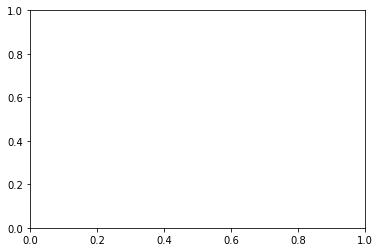

<Figure size 432x288 with 0 Axes>

In [4]:
# First, run for 8 hours to make an animation
fig, animate_artists, city_plotter = get_city_potter(plot_travelers=True)
city = City()
env_orig = Environment(
    events=[city, TravelerGenerator(lambda t: 100 * TravelerGenerator.DEFAULT_ARRIVAL_FUNC(t))],
    run_for=td('8 hours'),
    timeunit=td('10 seconds'),
    store_history=False
)
env_orig.run(verbose_func=city_plotter)

In [5]:
from IPython.display import Video


class tqdmlist(list):
    """Custom class to show the progress of the animation creation with tqdm (to not bother with progress callback)"""

    def __iter__(self):
        return self.tqdm_iter(super(tqdmlist, self).__iter__())

    @staticmethod
    def tqdm_iter(itr):
        for it in tqdm(list(itr)):  # to list to show progress
            yield it


p_animate_artists = tqdmlist(animate_artists)
ani = anim.ArtistAnimation(fig, p_animate_artists, interval=50, blit=True)
ani.save('anim-original.mp4', writer='ffmpeg')  # to_html5_video() can't find ffmpeg, so displaying this way
Video("anim-original.mp4")

0it [00:00, ?it/s]


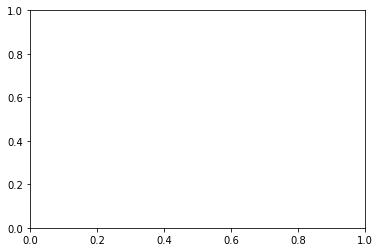

<Figure size 432x288 with 0 Axes>

In [6]:
# now run for an entire day
fig, animate_artists, city_plotter = get_city_potter(plot_travelers=False)
city = City()
env_orig = Environment(
    events=[city, TravelerGenerator(lambda t: 100 * TravelerGenerator.DEFAULT_ARRIVAL_FUNC(t))],
    run_for=td('1 day'),
    timeunit=td('10 seconds'),
    store_history=False
)
env_orig.run(verbose_func=city_plotter)

## Superblock Design

In [7]:
streets = np.array([
    # Roads around the neighborhood
    [0, 1, 300, 50, 1, 1, 4, 1],
    [1, 2, 300, 50, 1, 1, 4, 1],
    [2, 3, 220, 50, 1, 0, 2, 1],
    [3, 4, 170, 50, 1, 0, 2, 1],
    [7, 8, 200, 50, 1, 1, 2, 1],
    [8, 0, 170, 30, 1, 1, 2, 1],
    [7, 11, 140, 50, 1, 1, 2, 1],
    [11, 12, 230, 50, 1, 1, 2, 1],
    [12, 13, 150, 50, 1, 1, 2, 1],
    [13, 14, 300, 50, 2, 1, 2, 1],
    [14, 15, 120, 50, 2, 1, 2, 1],
    [15, 16, 200, 50, 2, 1, 2, 1],
    [16, 17, 130, 50, 1, 1, 2, 1],
    [17, 4, 120, 50, 1, 1, 2, 1],
    # One-way roads inside
    [4, 5, 200, 50, 1, 1, 2, 0],
    [5, 4, 200, 50, 0, 1, 2, 0],
    [5, 6, 120, 50, 0, 2, 2, 1],
    [6, 7, 300, 50, 0, 1, 2, 0],
    [7, 6, 300, 50, 1, 1, 2, 0],
    [8, 9, 250, 10, 0, 1, 2, 0],
    [9, 8, 250, 10, 1, 1, 2, 0],
    [1, 9, 250, 10, 1, 1, 2, 0],
    [9, 1, 250, 10, 0, 1, 2, 0],
    [1, 10, 250, 10, 1, 1, 2, 0],
    [10, 1, 250, 10, 0, 1, 2, 0],
    [9, 10, 120, 10, 0, 2, 2, 1],
    [3, 10, 170, 10, 0, 1, 2, 0],
    [10, 3, 170, 10, 1, 1, 2, 0],
    [6, 9, 170, 10, 1, 1, 2, 0],
    [9, 6, 170, 10, 0, 1, 2, 0],
    [5, 10, 170, 10, 1, 1, 2, 0],
    [10, 5, 170, 10, 0, 1, 2, 0],
    [11, 18, 250, 10, 1, 1, 2, 0],
    [18, 11, 250, 10, 0, 1, 2, 0],
    [12, 18, 200, 10, 0, 1, 2, 0],
    [18, 12, 200, 10, 1, 1, 2, 0],
    [14, 18, 220, 10, 1, 1, 2, 0],
    [18, 14, 220, 10, 0, 1, 2, 0],
    [18, 19, 200, 10, 0, 1, 2, 1],
    [17, 19, 200, 10, 1, 1, 2, 0],
    [19, 17, 200, 10, 0, 1, 2, 0],
    [5, 19, 250, 10, 0, 1, 2, 0],
    [6, 19, 260, 10, 0, 1, 2, 0],
    [15, 19, 400, 10, 0, 1, 2, 0],
    [19, 15, 400, 10, 1, 1, 2, 0],
    [14, 19, 460, 10, 0, 1, 2, 1],
])
# Add bidirectional streets from the other direction
bidir = streets[streets[:, -1] == 1].copy()
bidir[:, [0, 1]] = bidir[:, [1, 0]]
streets = np.vstack([streets, bidir])
streets
# %%
n_nodes = int(streets[:, :2].max() + 1)
streets[:, -1] = np.arange(len(streets))  # indices of streets
piv_streets = (pd.pivot(pd.DataFrame([streets[:, 0], streets[:, 1], streets[:, 2:]]).T, index=0, columns=1, values=2)
               .reindex(range(n_nodes)).reindex(range(n_nodes), axis=1))

piv_streets = np.array([[list(v) if type(v) == np.ndarray else [0, 0, 0, 0, 0, 0] for v in row]
                        for row in piv_streets.values])

0it [00:00, ?it/s]


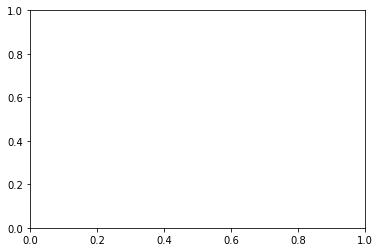

<Figure size 432x288 with 0 Axes>

In [8]:
fig, animate_artists, city_plotter = get_city_potter(plot_travelers=True)
city = City()
env_new = Environment(
    events=[city, TravelerGenerator(lambda t: 5 * n_nodes * TravelerGenerator.DEFAULT_ARRIVAL_FUNC(t))],
    run_for=td('8 hours'),
    timeunit=td('10 seconds'),
    store_history=False
)
env_new.run(verbose_func=city_plotter)

p_animate_artists = tqdmlist(animate_artists)
ani = anim.ArtistAnimation(fig, p_animate_artists, interval=50, blit=True)
ani.save('anim-new.mp4', writer='ffmpeg')
Video("anim-new.mp4")

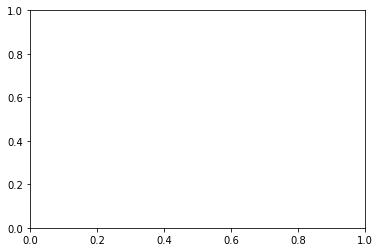

<Figure size 432x288 with 0 Axes>

In [9]:
# run for the whole day
fig, animate_artists, city_plotter = get_city_potter(plot_travelers=True)
city = City()
env_new = Environment(
    events=[city, TravelerGenerator(lambda t: 5 * n_nodes * TravelerGenerator.DEFAULT_ARRIVAL_FUNC(t))],
    run_for=td('1 day'),
    timeunit=td('10 seconds'),
    store_history=False
)
env_new.run(verbose_func=city_plotter)

<ipython-input-10-26f8099b4ab1>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bottom.set_xticklabels([pd.Timestamp(x * 60 * 60 * 24 * 1e9).strftime('%#I %p') for x in ax_bottom.get_xticks()])


<Figure size 432x288 with 0 Axes>

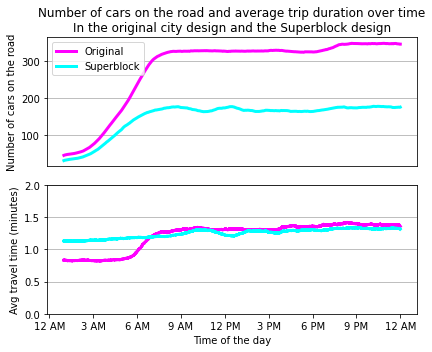

In [10]:
plt.close('all')
plt.cla()
plt.clf()
vehicles_orig = pd.DataFrame(env_orig.config['vehicles'], index=env_orig.timeline, columns=['cars', 'bikes', 'walkers'])
vehicles_new = pd.DataFrame(env_new.config['vehicles'], index=env_new.timeline, columns=['cars', 'bikes', 'walkers'])

cols = ['start', 'end', 'by', 'from', 'to']
trips_orig = pd.DataFrame(env_orig.config['trips'], columns=cols)
trips_new = pd.DataFrame(env_new.config['trips'], columns=cols)

trips_orig['duration'] = trips_orig['end'] - trips_orig['start']
trips_new['duration'] = trips_new['end'] - trips_new['start']

trips_orig['duration_min'] = trips_orig['duration'].astype('int64') / 1e9 / 60
trips_new['duration_min'] = trips_new['duration'].astype('int64') / 1e9 / 60

rolling_dur_orig = (trips_orig.set_index('start').sort_index().rolling(
    window=td('1 hour'), min_periods=(trips_orig['start'] < td('1 hour')).sum())
    .mean()['duration_min'])
rolling_dur_new = (trips_new.set_index('start').sort_index().rolling(
    window=td('1 hour'), min_periods=(trips_new['start'] < td('1 hour')).sum())
    .mean()['duration_min'])

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, figsize=(6, 5))

ref_date = pd.Timestamp.now().normalize()
ax_top.plot(ref_date + vehicles_orig.index, vehicles_orig['cars'].rolling(10 * 60).mean(),
            color='magenta', label='Original', lw=3)
ax_top.plot(ref_date + vehicles_new.index, vehicles_new['cars'].rolling(10 * 60).mean(),
            color='cyan', label='Superblock', lw=3)

ax_top.set_ylabel('Number of cars on the road')
ax_top.set_xticks([])
ax_top.grid(True, axis='y')
ax_top.legend(loc='upper left')
ax_top.set_title('Number of cars on the road and average trip duration over time\n'
                 'In the original city design and the Superblock design')

ax_bottom.plot(ref_date + rolling_dur_orig.index, rolling_dur_orig,
               color='magenta', lw=3, label='Original')
ax_bottom.plot(ref_date + rolling_dur_new.index, rolling_dur_new,
               color='cyan', lw=3, label='Superblock')

ax_bottom.set_xticklabels([pd.Timestamp(x * 60 * 60 * 24 * 1e9).strftime('%#I %p') for x in ax_bottom.get_xticks()])
ax_bottom.set_ylabel('Avg travel time (minutes)')
ax_bottom.set_xlabel('Time of the day')
ax_bottom.set_ylim(0, 2)
ax_bottom.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [11]:
print('Superblock design is faster by:', trips_orig['duration'].mean()-trips_new['duration'].mean())
print('p =', stats.ttest_ind(trips_orig['duration_min'], trips_new['duration_min'])[1])

Superblock design is faster by: 0 days 00:00:02.104860004
p = 0.00011331475496178324
